<a href="https://colab.research.google.com/github/Mjboothaus/titanic/blob/main/notebooks/eda_titanic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examination of the veracity of the Titanic dataset in Kaggle

In [1]:
import parent_in_path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib as dl
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path

sns.set_style('whitegrid');
sns.set();
plt.figure(figsize=(18,6));

%matplotlib inline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Import Titanic passenger list data

Is it possible to find actual date of birth for each passenger? These data sources only have age (it seems).

These data sets were downloaded from https://www.kaggle.com/c/titanic/data

In [2]:
data_path = "../data"

data_url = "https://raw.githubusercontent.com/Mjboothaus/titanic/main/data"


In [3]:
titanic_training_data_kaggle = pd.read_csv(f"{data_url}/train.csv")
titanic_test_data_kaggle = pd.read_csv(f"{data_url}/test.csv")

In [61]:
titanic_test_data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [47]:
from sklearn.datasets import fetch_openml

In [48]:
# load dataset

titanic_skl = fetch_openml('titanic', version=1, as_frame=True)
df = titanic_skl['data']
df['survived'] = titanic_skl['target']

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.8+ KB


In [49]:
type(titanic_skl)

sklearn.utils._bunch.Bunch

In [51]:
titanic_skl;

In [56]:
titanic_meta_data = titanic_skl["url"]
# !open $titanic_meta_data

In [59]:
df.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [63]:
# Assign Dependent and Independent variables
X = df.drop('survived', axis=1)
y = df['survived']

In [90]:
X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropSomeColumns(BaseEstimator, TransformerMixin):

    def __init__(self, cols):
        self.cols = cols if isinstance(cols, list) else [cols]

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # there is nothing to fit
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        return X[self.cols]

In [120]:
class DebugHelper(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(pd.DataFrame(X).head())
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [93]:
X_train.head()

,pclass,sex,age,sibsp,parch,embarked
1214,3.0,male,NaN,0.0,0.0,S
677,3.0,male,26.0,0.0,0.0,S
534,2.0,female,19.0,0.0,0.0,S
1174,3.0,female,NaN,8.0,2.0,S
864,3.0,female,28.0,0.0,0.0,S


In [125]:
# Set random state for reproducibility

RAND_STATE = 42

def fit_model_predict_outcome(X_train=None, X_test=None, y_train=None, y_test=None, drop_features=None):
    
    # handle numeric features
    numeric_features = ['age']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    # handle categorical features
    categorical_features = ['sex', 'pclass']

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', OneHotEncoder(handle_unknown='ignore'))])

    debug_transformer = Pipeline(steps=[
        ("debug", DebugHelper())
    ])

    # Create a transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("debug1", debug_transformer)
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Run the classifier
    classifier = DecisionTreeClassifier(
        random_state=RAND_STATE,
        class_weight='balanced',
        max_depth=3
        )
  
    # pipe = Pipeline(steps=[("drop_features", DropSomeColumns(drop_features))])
    # pipe.transform(X_train)

    # Set the Pipeline
    model = Pipeline(steps=[
        ('drop_cols', DropSomeColumns(drop_features)),
        ('preprocessor', preprocessor),
        ('classifier', classifier)])


    # Fit the pipeline
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    print(f'Model score: {model.score(X_test, y_test)}')

    # compute the classification report
    print(classification_report(y_test, y_pred))

In [126]:
drop_features = ['sibsp', 'parch', 'embarked']

In [127]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked'], dtype='object')

In [128]:
fit_model_predict_outcome(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, drop_features=drop_features)

TypeError: 'tuple' object is not callable

In [ ]:
fit_model_predict_outcome(titanic_test_data_kaggle)

In [46]:
""" 
    Why don't we impute using the dataframe-wide median? Because data contains heterogeneous groups 
    e.g. 1st-class Titanic passengers tended to be older than 3rd-class passengers
"""

print(titanic_training_data_kaggle.groupby("Pclass")["Age"].median(), "\n")
print(titanic_training_data_kaggle["Age"].median())

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64 

28.0


In [4]:
titanic_training_data_kaggle.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


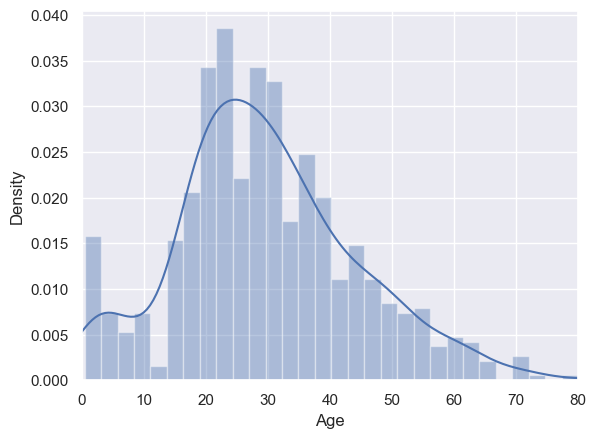

In [5]:
ax = sns.distplot(titanic_training_data_kaggle['Age'].dropna(), bins=30)
ax.set_xlim(0,80);


In [6]:
titanic_training_data_kaggle['Name'] = titanic_training_data_kaggle['Name'].apply(lambda x : x.replace(u'\xa0', ' '))

In [7]:
def extract_names(nameString, return_type):
    
    firstname = 'XXX NO FIRSTNAME XXX'
    othernames = ''
    
    tmp = nameString.split()
    if tmp[0][-1] == ',':
        surname = tmp[0][0:len(tmp[0])-1]
        title = tmp[1][0:len(tmp[1])-1]
        mynames = tmp[2:len(tmp)]
    else:
        surname = tmp[0] + ' ' + tmp[1][0:len(tmp[0])-1]
        title = tmp[2][0:len(tmp[2])-1]
        mynames = tmp[3:len(tmp)]

    firstname = mynames[0]
    othernames = ''
    for name in mynames[1:len(mynames)-1]:
        othernames = othernames + name + ' '
    othernames = othernames.rstrip()       
        
    try:
        if mynames[len(mynames)-1][-1] == ')':          # extract female/wife name
            othernames = ''
            for name in mynames:
                othernames = othernames + name + ' '
                if name[0] == '(':
                    othernames = ''
                    firstname = name[1:len(name)]
            othernames = othernames.rstrip()
            othernames = othernames[0:len(othernames)-1]             
    except:
        pass
    
    if return_type == 1:
        return title
    elif return_type == 2:
        return surname
    elif return_type == 3:
        return firstname
    else:
        return othernames

In [8]:
titanic_training_data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
titanic_test_data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Merge the Kaggle train and test datasets into one (for comparison to other Titanic data sets/sources)

In [10]:
titanic_data_kaggle = pd.merge(titanic_training_data_kaggle, titanic_test_data_kaggle, how='outer')

In [11]:
titanic_data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


So in the combined dataset of 1309 (= 891 train + 418 test) passengers, there are 1046 non-null age values.

Let's extract the components of the 'Name' field into title, surname, first name and other names.

In [12]:
titanic_data_kaggle['Title'] = titanic_data_kaggle['Name'].apply(lambda x : extract_names(x, 1))
titanic_data_kaggle['Surname'] = titanic_data_kaggle['Name'].apply(lambda x : extract_names(x, 2))
titanic_data_kaggle['Firstname'] = titanic_data_kaggle['Name'].apply(lambda x : extract_names(x, 3))
titanic_data_kaggle['Othernames'] = titanic_data_kaggle['Name'].apply(lambda x : extract_names(x, 4))

In [13]:
titanic_data_kaggle_sort_age = titanic_data_kaggle.sort_values(by=['Age', 'Name'])
titanic_data_kaggle_sort_age.reset_index(inplace=True)

Now put the other dataset(s) age data on this plot too.

In [14]:
titanic_data_wikipedia = pd.read_html('https://en.m.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic',header=0)

In [15]:
titanic_facts_tables = pd.read_html('http://www.titanicfacts.net/titanic-passenger-list.html',header=0)

In [16]:
titanic_facts_tables[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Surname                     324 non-null    object
 1   First Names                 324 non-null    object
 2   Age                         324 non-null    object
 3   Boarded                     324 non-null    object
 4   Survivor (S) or Victim (†)  324 non-null    object
dtypes: object(5)
memory usage: 12.8+ KB


In [17]:
titanic_facts_tables[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Surname                     284 non-null    object
 1   First Names                 284 non-null    object
 2   Age                         284 non-null    object
 3   Boarded                     284 non-null    object
 4   Survivor (S) or Victim (†)  284 non-null    object
dtypes: object(5)
memory usage: 11.2+ KB


In [18]:
titanic_facts_tables[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Surname                     709 non-null    object
 1   First Names                 709 non-null    object
 2   Age                         709 non-null    object
 3   Boarded                     709 non-null    object
 4   Survivor (S) or Victim (†)  709 non-null    object
dtypes: object(5)
memory usage: 27.8+ KB


So the "Titanic Facts" has the data spread across 3 tables with 324 (1st class), 284 (2nd class) and 709 (3rd class) passengers (1317 total) respectively. There is age data for all 1317 passengers. Contrast this with 1309 passengers in the Kaggle dataset [which does not claim to be complete -- in fact, somewhat disappointingly, there does not appear to be a reference for the data] with only 1046 age values.

In [19]:
titanic_facts = pd.merge(pd.merge(titanic_facts_tables[0], titanic_facts_tables[1], how='outer'), titanic_facts_tables[2], how='outer')

In [20]:
def export_df_to_csv_file_if_path_exists(df, file_path):
  if Path(file_path).exists():
    df.to_csv(file_path)
    print(f"File exported to {file_path}")
  else:
    print(f"Unable to export to {file_path}")

In [21]:
export_df_to_csv_file_if_path_exists(titanic_facts, f"{data_path}/titanic_facts.csv")

File exported to ../data/titanic_facts.csv


In [22]:
titanic_facts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 1316
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Surname                     1317 non-null   object
 1   First Names                 1317 non-null   object
 2   Age                         1317 non-null   object
 3   Boarded                     1317 non-null   object
 4   Survivor (S) or Victim (†)  1317 non-null   object
dtypes: object(5)
memory usage: 61.7+ KB


In [23]:
# Also could go heavy-handed with:
# pd.to_numeric(df['y'], errors='coerce')

def convert_age(age):
    try:
        return float(age)
    except Exception:
        try:
            return float(age[:-1]) / 12.0
        except Exception:
            return np.nan

In [24]:
titanic_facts['Age'] = titanic_facts['Age'].apply(lambda age : convert_age(age))

Need to convert age from string to float

In [25]:
titanic_facts_sort_age = titanic_facts.sort_values(by=['Age', 'Surname'])
titanic_facts_sort_age.reset_index(inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Age'>

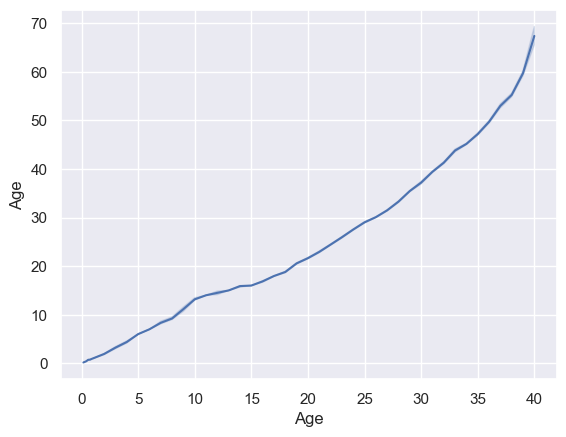

In [26]:
sns.lineplot(x=titanic_facts_sort_age['Age'], y=titanic_data_kaggle_sort_age['Age'])

In [27]:
# DEPRECATED

# sns.plt.plot(titanic_facts_sort_age['Age'])
# sns.plt.plot(titanic_data_kaggle_sort_age['Age'], 'g')

In [28]:
titanic_facts_sort_age.info()
print()
titanic_data_kaggle_sort_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       1317 non-null   int64  
 1   Surname                     1317 non-null   object 
 2   First Names                 1317 non-null   object 
 3   Age                         1315 non-null   float64
 4   Boarded                     1317 non-null   object 
 5   Survivor (S) or Victim (†)  1317 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 61.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Survived     891 non-null    float64
 3   Pclass       1309 non-null   int64  
 4   Name      

In [29]:
titanic_facts_sort_age['Name'] = titanic_facts_sort_age['Surname'] + titanic_facts_sort_age['First Names']

Test the operation of the get_close_matches( ) method to see if we can merge the datasets based on the name fields.

In [30]:
for i in range(5):
    tmp = dl.get_close_matches(titanic_data_kaggle_sort_age['Name'].iloc[i], titanic_facts_sort_age['Name'])
    try:
        print(f'{len(tmp)}: {tmp[0]} / ' + titanic_data_kaggle_sort_age['Name'].iloc[i])
    except Exception:
        print('No match' + ' / ' + titanic_data_kaggle_sort_age['Name'].iloc[i])
              

1: DeanMiss Elizabeth Gladys “Millvina” / Dean, Miss. Elizabeth Gladys Millvina""
1: DanbomMaster Gilbert Sigvard Emanuel / Danbom, Master. Gilbert Sigvard Emanuel
No match / Thomas, Master. Assad Alexander
1: HämäläinenMaster Viljo Unto Johannes / Hamalainen, Master. Viljo
2: BacliniMiss Eugenie / Baclini, Miss. Eugenie


In [31]:
def match_name(name):
    try:
        return dl.get_close_matches(name, titanic_facts_sort_age['Name'])[0]
    except Exception:
        return 'No name match'

titanic_data_kaggle_sort_age['Name'] = titanic_data_kaggle_sort_age['Name'].apply(lambda name: match_name(name))

In [32]:
titanic_data_kaggle_sort_age[titanic_data_kaggle_sort_age['Name']!='No name match']

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Firstname,Othernames
0,1245,1246,NaN,3,DeanMiss Elizabeth Gladys “Millvina”,female,0.17,1,2,C.A. 2315,20.5750,NaN,S,Miss,Dean,Elizabeth,Gladys
1,1092,1093,NaN,3,DanbomMaster Gilbert Sigvard Emanuel,male,0.33,0,2,347080,14.4000,NaN,S,Master,Danbom,Gilbert,Sigvard
3,755,756,1.0,2,HämäläinenMaster Viljo Unto Johannes,male,0.67,1,1,250649,14.5000,NaN,S,Master,Hamalainen,Viljo,
4,644,645,1.0,3,BacliniMiss Eugenie,female,0.75,2,1,2666,19.2583,NaN,C,Miss,Baclini,Eugenie,
5,469,470,1.0,3,BacliniMiss Helene Barbara,female,0.75,2,1,2666,19.2583,NaN,C,Miss,Baclini,Helene,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,55,56,1.0,1,WoolnerMr Hugh,male,NaN,0,0,19947,35.5000,C52,S,Mr,Woolner,Hugh,
1305,495,496,0.0,3,Yousseff (Abi Saab)Mr Gerios,male,NaN,0,0,2627,14.4583,NaN,C,Mr,Yousseff,Gerious,
1306,240,241,0.0,3,Jabbur (Zabour)Miss Thamine,female,NaN,1,0,2665,14.4542,NaN,C,Miss,Zabour,Thamine,
1307,1235,1236,NaN,3,Van BilliardMaster James William,male,NaN,1,1,A/5. 851,14.5000,NaN,S,Master,van Bi,James,


In [33]:
titanic_data_kaggle_sort_age['KaggleAge'] = titanic_data_kaggle_sort_age['Age']

In [34]:
titanic_merged = titanic_data_kaggle_sort_age.merge(titanic_facts_sort_age, how='left', left_on='Name', right_on='Name')

In [35]:
titanic_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 0 to 1310
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index_x                     1311 non-null   int64  
 1   PassengerId                 1311 non-null   int64  
 2   Survived                    892 non-null    float64
 3   Pclass                      1311 non-null   int64  
 4   Name                        1311 non-null   object 
 5   Sex                         1311 non-null   object 
 6   Age_x                       1048 non-null   float64
 7   SibSp                       1311 non-null   int64  
 8   Parch                       1311 non-null   int64  
 9   Ticket                      1311 non-null   object 
 10  Fare                        1310 non-null   float64
 11  Cabin                       295 non-null    object 
 12  Embarked                    1309 non-null   object 
 13  Title                       1311 

In [36]:
titanic_merged['AgeDiff'] = titanic_merged['KaggleAge'] - titanic_merged['Age_y']

In [37]:
titanic_merged['AgeDiff'] = titanic_merged['AgeDiff'].dropna()
titanic_merged['AgeDiff'].describe()

count    975.000000
mean       0.161197
std        4.856543
min      -26.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       51.000000
Name: AgeDiff, dtype: float64

In [38]:
export_df_to_csv_file_if_path_exists(titanic_merged, f"{data_path}/titanic_merged.csv")

File exported to ../data/titanic_merged.csv


In [39]:
titanic_merged['AgeDiffMoreEps'] = titanic_merged['AgeDiff'].apply(lambda agediff : abs(agediff) > 2)
titanic_merged.corr()

,index_x,PassengerId,Survived,Pclass,Age_x,SibSp,Parch,Fare,KaggleAge,index_y,Age_y,AgeDiff,AgeDiffMoreEps
index_x,1.000000,1.000000,-0.005865,-0.037854,0.029089,-0.055475,0.008689,0.031140,0.029089,-0.054718,0.024725,0.040288,0.033635
PassengerId,1.000000,1.000000,-0.005865,-0.037854,0.029089,-0.055475,0.008689,0.031140,0.029089,-0.054718,0.024725,0.040288,0.033635
Survived,-0.005865,-0.005865,1.000000,-0.338965,-0.078270,-0.034886,0.082010,0.257613,-0.078270,-0.317012,-0.055691,-0.052137,0.040006
Pclass,-0.037854,-0.037854,-0.338965,1.000000,-0.406386,0.060174,0.017738,-0.558854,-0.406386,0.871123,-0.396100,-0.031650,-0.043333
Age_x,0.029089,0.029089,-0.078270,-0.406386,1.000000,-0.244189,-0.151426,0.177961,1.000000,-0.334432,0.944186,0.169961,0.096539
SibSp,-0.055475,-0.055475,-0.034886,0.060174,-0.244189,1.000000,0.373791,0.160539,-0.244189,0.052222,-0.245553,-0.024376,-0.023593
Parch,0.008689,0.008689,0.082010,0.017738,-0.151426,0.373791,1.000000,0.221798,-0.151426,-0.009180,-0.141398,0.021793,-0.036913
Fare,0.031140,0.031140,0.257613,-0.558854,0.177961,0.160539,0.221798,1.000000,0.177961,-0.454378,0.143106,0.057666,0.002656
KaggleAge,0.029089,0.029089,-0.078270,-0.406386,1.000000,-0.244189,-0.151426,0.177961,1.000000,-0.334432,0.944186,0.169961,0.096539
index_y,-0.054718,-0.054718,-0.317012,0.871123,-0.334432,0.052222,-0.009180,-0.454378,-0.334432,1.000000,-0.340924,0.015645,-0.059278


In [40]:
titanic_merged['AgeDiff'].describe()

count    975.000000
mean       0.161197
std        4.856543
min      -26.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       51.000000
Name: AgeDiff, dtype: float64

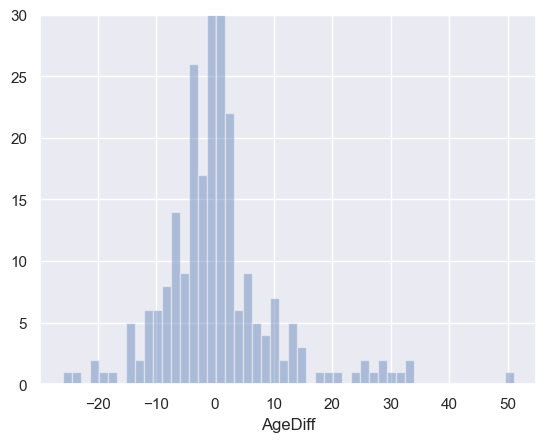

In [41]:
ax = sns.distplot(titanic_merged['AgeDiff'].dropna(), kde=False, bins=50)
ax.set_ylim(0,30);

So for the most part, allowing for the NaN differences in the data sets they look pretty similar (other than the max age of 80). So let's look at some of the other top values.

In [42]:
titanic_facts_sort_age['Age'].sort_values(na_position='first').tail(5)

1310    70.0
1313    71.0
1311    71.0
1312    71.0
1314    74.0
Name: Age, dtype: float64

In [43]:
titanic_data_kaggle_sort_age['Age'].sort_values(na_position='first').tail(5)

1041    71.0
1042    71.0
1043    74.0
1044    76.0
1045    80.0
Name: Age, dtype: float64

So it seems we have a 76 year old -- wonder if this age is also spurious?

In [44]:
titanic_data_kaggle_sort_age.iloc[1044]

index                                  987
PassengerId                            988
Survived                               NaN
Pclass                                   1
Name           CavendishMrs Julia Florence
Sex                                 female
Age                                   76.0
SibSp                                    1
Parch                                    0
Ticket                               19877
Fare                                 78.85
Cabin                                  C46
Embarked                                 S
Title                                  Mrs
Surname                          Cavendish
Firstname                            Julia
Othernames                 Florence Siegel
KaggleAge                             76.0
Name: 1044, dtype: object

Yes -- another one! Julia Florence Cavendish (who survived) was 25 at the time of the disaster. Her age at death was 76. c.f. https://www.encyclopedia-titanica.org/titanic-survivor/julia-florence-cavendish.html